# Baseline model for progression prediction

## Set-up

### Import librairies

In [1]:
import os, sys

from tqdm.notebook import tqdm
from typing import List, Dict

import pandas as pd
import numpy as np
import networkx as nx

import plotly.express as px
import plotly.io as pio

pio.templates.default = 'seaborn'

In [2]:
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))

### Fetch data

In [74]:
from utils import fetch_data

labels, lesions, patients = fetch_data(suspicious=0.5, verbose=1)

len(labels.index.unique()), len(lesions.reset_index().gpcr_id.unique()), len(patients.reset_index().gpcr_id.unique())

Post-1 study lesions extracted for 106 patients
Post-2 study labels added for 66 patients
The intersection of datasets showed 55 potential datapoints.


(55, 55, 55)

In [37]:
# post-1 or not
lesions = lesions.reset_index()
lesions = lesions[lesions.study_name.isin(['post-01'])]
lesions = lesions.drop(columns=['study_name'])

In [41]:
studies = lesions.merge(patients, on='gpcr_id', how='inner')

In [73]:
# LABELS
from utils import FILES, CONNECTION_DIR, DATA_FOLDERS

progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1],
                                        FILES[DATA_FOLDERS[1]]['progression']))
progression['pseudorecist'] = progression.pseudorecist.eq('NPD').mul(1)

progression = progression[progression.study_name == 'post-01']

labels = progression.set_index('gpcr_id').pseudorecist

In [75]:
import itertools

numerical_feats = list(lesions.select_dtypes(np.number).columns)
numerical_feats.remove('mtv')

lesions_agg = lesions.groupby(['gpcr_id', 'study_name']).agg({
        'mtv': np.sum,
        **{feat: np.mean for feat in numerical_feats},
        'assigned_organ': pd.Series.tolist,
    }).reset_index()

studies = lesions_agg.merge(patients, on=['gpcr_id', 'study_name'], how='inner')

In [76]:
studies['prior_targeted_therapy'] = studies['prior_targeted_therapy'].astype(bool)
studies['BRAF_MUTATION'] = studies['BRAF_MUTATION'].eq('y')
studies['NRAS_MUTATION'] = studies['NRAS_MUTATION'].eq('y')

In [77]:
patients_agg = studies.groupby('gpcr_id').agg({
        'mtv': np.mean,
        **{feat: np.mean for feat in numerical_feats},
        'assigned_organ': pd.Series.tolist,
        'sex': pd.Series.mode,
        'NRAS_MUTATION': pd.Series.mode,
        'BRAF_MUTATION': pd.Series.mode,
        'immuno_therapy_type': pd.Series.tolist,
        'concomittant_tvec': pd.Series.mode,
        'prior_treatment': pd.Series.mode,
        'nivo_maintenance': pd.Series.mode
    }).reset_index()

In [78]:
patients_agg.assigned_organ = patients_agg.assigned_organ \
    .apply(lambda l: itertools.chain(*l)).apply(set).apply(list)
patients_agg.immuno_therapy_type = patients_agg.immuno_therapy_type \
    .apply(lambda l: itertools.chain(*l)).apply(set).apply(list)

### Prepare data

In [79]:
dataset = patients_agg.set_index('gpcr_id')

In [80]:
from utils import Preprocessor

# Separate features by type
numerical = list(dataset.select_dtypes(np.number).columns)
categorical = list(dataset.select_dtypes([bool, object]).columns)
multivalue = ['immuno_therapy_type', 'assigned_organ']

# Remove multivalue features from categorical ones
for feature in multivalue:
    categorical.remove(feature)
    
features_range = list(range(len(numerical) + len(categorical) + len(multivalue)))
bp = np.cumsum([len(numerical), len(categorical), len(multivalue)])

# Build PipeLine of ColumnTransformers
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


ct = Pipeline([
    ('imputers', ColumnTransformer([
        ('median', SimpleImputer(strategy='median'), numerical),
        ('frequent', SimpleImputer(strategy='most_frequent'), categorical)
    ], remainder='passthrough')),
    ('preprocess', ColumnTransformer([
        ('scaler', StandardScaler(), features_range[0:bp[0]]),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), features_range[bp[0]:bp[1]]),
        ('count-vec1', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][0]),
        ('count-vec2', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][1])
    ], remainder='passthrough')),
])


ppor = Preprocessor(
    pipe=ct,
    feats_out_fn=lambda ct: ct.named_steps['imputers'].transformers_[0][2] \
        + list(ct.named_steps['preprocess'].transformers_[1][1].get_feature_names_out()) \
        + list(ct.named_steps['preprocess'].transformers_[2][1].get_feature_names_out())
        + list(ct.named_steps['preprocess'].transformers_[3][1].get_feature_names_out()))


## Testing different classifiers

In [81]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=7),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=.01, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(penalty='l2', solver='liblinear')]

In [92]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

storage = []

labels = labels.loc[dataset.index]

kfold = KFold(n_splits=5, shuffle=True)

pbar = tqdm(enumerate(kfold.split(labels.index)), total=5)
for fold, (I_train, I_test) in pbar:
    pbar.set_description(f'Fold {fold}')
    
    ppor.fit(dataset.iloc[I_train])

    X_train = ppor.transform(dataset.iloc[I_train]) 
    X_test = ppor.transform(dataset.iloc[I_test]) 

    y_train = labels.iloc[I_train]
    y_test = labels.iloc[I_test]
    
    for name, clf in zip(names, classifiers):

        clf.fit(X_train, y_train)
    
        y_pred = clf.predict(X_test)
        
        # Add testing accuracy
        storage.append(
            dict(model=name,
                 metric='Accuracy - testing',
                 value=accuracy_score(y_test, y_pred))
        )
        
        # Add ROC AUC score
        storage.append(
            dict(model=name,
                 metric='ROC AUC - testing',
                 value=roc_auc_score(y_test, y_pred))
        )
        
        # Add other binary classification metrics
        bin_class_metrics = precision_recall_fscore_support(y_test, y_pred, average='binary')
        for value, metric in zip(list(bin_class_metrics)[:-1], ['precision', 'recall', 'fscore']):
            storage.append(dict(model=name, metric=(metric.capitalize() + ' - testing'), value=value))
        

  0%|          | 0/5 [00:00<?, ?it/s]

In [93]:
pd.DataFrame(storage).groupby('model').mean().sort_values('value', ascending=False)

,value
model,
RBF SVM,0.684561
Linear SVM,0.669033
AdaBoost,0.580758
Logistic Regression,0.559211
Random Forest,0.536911
Neural Net,0.534088
Gaussian Process,0.505576
Decision Tree,0.504999
Nearest Neighbors,0.481001


In [59]:
top_h_legend = dict(orientation='h', yanchor="bottom", y=1.02)

In [60]:
results_agg.pivot(index='model_', columns='metric_')

value_mean                                       \
metric_       Accuracy - testing Fscore - testing Precision - testing   
model_                                                                  
Decision Tree           0.552727         0.555934            0.603095   
Linear SVM              0.534545         0.691573            0.568889   
RBF SVM                 0.590909         0.736352            0.590909   

                                                          value_std  \
metric_       ROC AUC - testing Recall - testing Accuracy - testing   
model_                                                                
Decision Tree          0.551667         0.536667           0.132740   
Linear SVM             0.455000         0.910000           0.106484   
RBF SVM                0.500000         1.000000           0.128565   

                                                                      \
metric_       Fscore - testing Precision - testing ROC AUC - testing   
model_                                                                 
Decision Tree         0.226985            0.233351          0.125610   
Linear SVM            0.092106            0.125986          0.043839   
RBF SVM               0.100687            0.128565          0.000000   

                                
metric_       Recall - testing  
model_                          
Decision Tree         0.258306  
Linear SVM            0.087678  
RBF SVM               0.000000

In [94]:
import plotly.express as px

results = pd.DataFrame(storage)

top_three = ['RBF SVM', 'Linear SVM', 'AdaBoost']
# top_three = ['Random Forest', 'Nearest Neighbors', 'Decision Tree']

results = results[results.model.isin(top_three)]

results_agg = results.groupby(['metric', 'model']).agg({'value':['mean', 'std']}).reset_index()
results_agg.columns = list(map('_'.join, results_agg.columns.values))

px.bar(results_agg, #.sort_values(['metric_', 'value_mean'], ascending=[True, False]),
       x='metric_', y='value_mean', color='model_', error_y='value_std', barmode='group') \
       .update_layout(legend=top_h_legend, xaxis_title='Evaluation metric', yaxis_title='Performance')

In [97]:
results['metric'] = results['metric'].apply(lambda m: m.split(' ')[0])

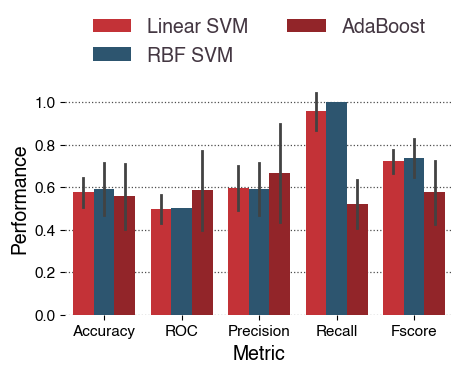

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../assets/graphmel.mplstyle')

fig, ax = plt.subplots()

sns.barplot(data=results, x='metric', y='value', hue='model', ci='sd', errwidth=2.0,
            ax=ax)
    #    .update_layout(legend=top_h_legend, xaxis_title='Evaluation metric', yaxis_title='Performance')
    
ax.set_ylabel('Performance')
ax.set_xlabel('Metric')

lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)

#########
filename = '../report/figures/baseline_timewise.png'

# Set accurate dimensions for LaTeX report
golden_ratio = (5 ** 0.5 - 1) / 2
latex_width = 5.0  # in inches
fig.set_size_inches(latex_width, latex_width * golden_ratio)

plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
def get_best_worst_coefs(classifier):
    for feature, coef in list(sorted(zip(ppor.get_feature_names_out(), classifier.coef_.reshape(-1)), key=lambda x: x[1], reverse=True))[:5]:
        print(f'{feature:<35} {coef:,.4f}')
        
    for feature, coef in list(sorted(zip(ppor.get_feature_names_out(), classifier.coef_.reshape(-1)), key=lambda x: x[1], reverse=False))[:5]:
        print(f'{feature:<35} {coef:,.4f}')

In [ ]:
list(zip(categorical, range(len(categorical))))

[('sex', 0),
 ('NRAS_MUTATION', 1),
 ('BRAF_MUTATION', 2),
 ('concomittant_tvec', 3),
 ('prior_treatment', 4),
 ('nivo_maintenance', 5)]

In [ ]:
for classifier in ['Logistic Regression', 'Linear SVM']:
    
    print(f'\n{classifier}:\n====')
    print(get_best_worst_coefs(dict(zip(names, classifiers))[classifier]))


Logistic Regression:
====
original_shape_majoraxislength      0.6227
spleen                              0.5880
lung                                0.5630
suv_uniformity                      0.5551
other_lowerlimb                     0.4784
other_thorax                        -1.0213
mtv                                 -0.7341
original_shape_maximum2ddiametercolumn -0.6651
suv_skewness                        -0.5640
nivo                                -0.4589
None

Linear SVM:
====
suv_energy                          0.0642
other_lowerlimb                     0.0609
suv_uniformity                      0.0605
x1_True                             0.0498
x0_female                           0.0465
mtv                                 -0.1591
original_shape_maximum2ddiametercolumn -0.1209
other_thorax                        -0.0846
original_shape_maximum2ddiameterrow -0.0741
original_shape_surfacearea          -0.0701
None


In [ ]:
dtc = dict(zip(names, classifiers))['Decision Tree']

print('Decision Tree\n====')

for feature, coef in list(sorted(zip(ppor.get_feature_names_out(), dtc.feature_importances_.reshape(-1)), key=lambda x: x[1], reverse=True))[:10]:
    print(f'{feature:<35} {coef:,.4f}')


Decision Tree
====
original_shape_maximum3ddiameter    0.2130
mtv                                 0.1997
original_shape_meshvolume           0.1660
suv_energy                          0.1068
original_shape_flatness             0.0890
original_shape_majoraxislength      0.0774
original_shape_voxelvolume          0.0708
original_shape_minoraxislength      0.0442
original_shape_maximum2ddiameterslice 0.0332
original_shape_elongation           0.0000
